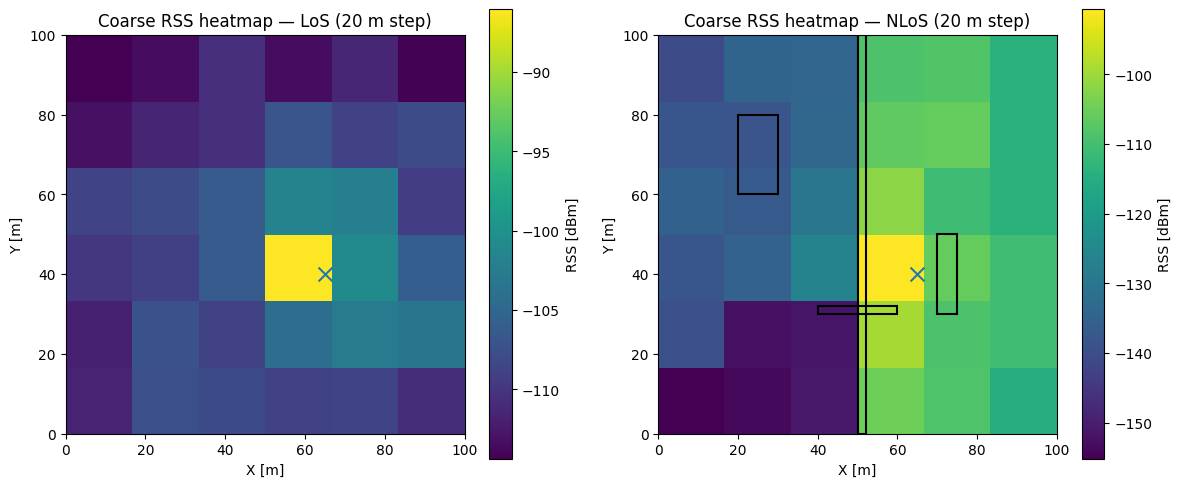

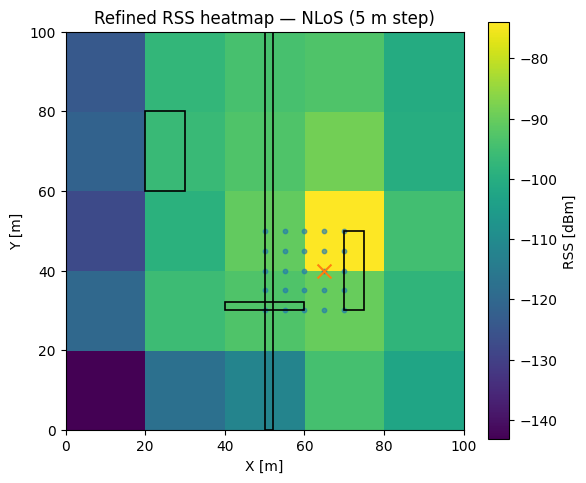

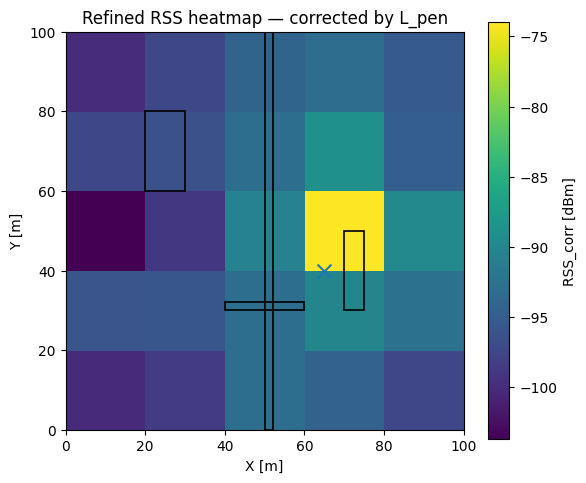

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import euclidean

np.random.seed(42)
area_size = 100
coarse_step = 20
fine_step = 5
true_ue_pos = np.array([65, 40])
rss0 = -75
d0 = 1.0
n = 2.0
shadowing_std = 2.0
f_GHz = 3.5

# Penetration losses
L_pen = {
    "glass": 2.0 + 0.2 * f_GHz,
    "irr_glass": 23.0 + 0.3 * f_GHz,
    "concrete": 5.0 + 4.0 * f_GHz,
    "wood": 4.85 + 0.12 * f_GHz
}


OBSTACLES = [
    {"xmin": 40, "xmax": 60, "ymin": 30, "ymax": 32, "mat": "concrete"},
    {"xmin": 20, "xmax": 30, "ymin": 60, "ymax": 80, "mat": "glass"},
    {"xmin": 70, "xmax": 75, "ymin": 30, "ymax": 50, "mat": "wood"},
    {"xmin": 50, "xmax": 52, "ymin":  0, "ymax":100, "mat": "irr_glass"},
]

def segment_hits_rect(p0, p1, rect, samples=200):
    xs = np.linspace(p0[0], p1[0], samples)
    ys = np.linspace(p0[1], p1[1], samples)
    inside_x = (xs >= rect["xmin"]) & (xs <= rect["xmax"])
    inside_y = (ys >= rect["ymin"]) & (ys <= rect["ymax"])
    return bool(np.any(inside_x & inside_y))

def materials_on_path(p0, p1):
    mats = []
    for r in OBSTACLES:
        if segment_hits_rect(p0, p1, r):
            mats.append(r["mat"])
    return mats

def simulate_rss_los(pos, ue_pos):
    d = euclidean(pos, ue_pos)
    d = max(d, 1.0)
    path_loss = 10 * n * np.log10(d / d0)
    shadowing = np.random.normal(0, shadowing_std)
    return rss0 - path_loss + shadowing

def simulate_rss_nlos(pos, ue_pos):
    d = euclidean(pos, ue_pos)
    d = max(d, 1.0)
    path_loss = 10 * n * np.log10(d / d0)
    shadowing = np.random.normal(0, shadowing_std)

    mats = materials_on_path(pos, ue_pos)
    L_extra = sum(L_pen[m] for m in mats) if mats else 0.0

    rss_raw = rss0 - path_loss - L_extra + shadowing
    label = "LOS" if not mats else "+".join(mats)
    return rss_raw, label, L_extra

x_coarse = np.arange(0, area_size + 1, coarse_step)
y_coarse = np.arange(0, area_size + 1, coarse_step)
coarse_positions = np.array([(x, y) for x in x_coarse for y in y_coarse])

# LoS baseline
rss_coarse_los = np.array([simulate_rss_los(pos, true_ue_pos) for pos in coarse_positions])

# NLoS with obstacles
rss_raw_list, label_list, L_list = [], [], []
for pos in coarse_positions:
    rss_raw, lab, L = simulate_rss_nlos(pos, true_ue_pos)
    rss_raw_list.append(rss_raw); label_list.append(lab); L_list.append(L)
rss_coarse_nlos = np.array(rss_raw_list)
rss_coarse_corr = rss_coarse_nlos + np.array(L_list)  # ideal correction upper bound

coarse_df = pd.DataFrame(coarse_positions, columns=["X [m]","Y [m]"])
coarse_df["RSS_raw [dBm]"] = np.round(rss_coarse_nlos, 2)
coarse_df["Path"] = label_list
coarse_df["L_pen [dB]"] = np.round(L_list, 2)
coarse_df["RSS_corr [dBm]"] = np.round(coarse_df["RSS_raw [dBm]"] + coarse_df["L_pen [dB]"], 2)
coarse_df.to_csv("Table_3_1_RSS_Coarse_Scan_NLoS.csv", index=False)

warm_idx = np.argmax(coarse_df["RSS_corr [dBm]"].to_numpy())
warm_center = coarse_positions[warm_idx]

x_fine = np.arange(warm_center[0] - 10, warm_center[0] + 11, fine_step)
y_fine = np.arange(warm_center[1] - 10, warm_center[1] + 11, fine_step)
# clip to area
x_fine = x_fine[(x_fine>=0) & (x_fine<=area_size)]
y_fine = y_fine[(y_fine>=0) & (y_fine<=area_size)]
fine_positions = np.array([(x, y) for x in x_fine for y in y_fine])

rss_f_raw, f_label, f_L = [], [], []
for pos in fine_positions:
    r, lab, L = simulate_rss_nlos(pos, true_ue_pos)
    rss_f_raw.append(r); f_label.append(lab); f_L.append(L)
rss_f_raw = np.array(rss_f_raw)
rss_f_corr = rss_f_raw + np.array(f_L)

fine_df = pd.DataFrame(fine_positions, columns=["X [m]","Y [m]"])
fine_df["RSS_raw [dBm]"] = np.round(rss_f_raw, 2)
fine_df["Path"] = f_label
fine_df["L_pen [dB]"] = np.round(f_L, 2)
fine_df["RSS_corr [dBm]"] = np.round(rss_f_corr, 2)
fine_df.to_csv("Table_3_2_RSS_Fine_Scan_NLoS.csv", index=False)

# plots
def to_grid(vals, xs, ys):
    """Reshape flat list into a (len(ys), len(xs)) grid for imshow."""
    return vals.reshape(len(xs), len(ys)).T

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
xi, yi = np.unique(coarse_positions[:,0]), np.unique(coarse_positions[:,1])
Z_los = to_grid(rss_coarse_los, xi, yi)
im0 = axs[0].imshow(Z_los, extent=(0, area_size, 0, area_size), origin="lower")
axs[0].scatter(*true_ue_pos, marker="x", s=100)
axs[0].set_title("Coarse RSS heatmap — LoS (20 m step)")
axs[0].set_xlabel("X [m]"); axs[0].set_ylabel("Y [m]")
fig.colorbar(im0, ax=axs[0], label="RSS [dBm]")

Z_nlos = to_grid(rss_coarse_nlos, xi, yi)
im1 = axs[1].imshow(Z_nlos, extent=(0, area_size, 0, area_size), origin="lower")
axs[1].scatter(*true_ue_pos, marker="x", s=100)
axs[1].set_title("Coarse RSS heatmap — NLoS (20 m step)")
axs[1].set_xlabel("X [m]"); axs[1].set_ylabel("Y [m]")

for r in OBSTACLES:
    rect = Rectangle((r["xmin"], r["ymin"]), r["xmax"]-r["xmin"], r["ymax"]-r["ymin"],
                     fill=False, linewidth=1.5)
    axs[1].add_patch(rect)
fig.colorbar(im1, ax=axs[1], label="RSS [dBm]")
plt.tight_layout()
plt.savefig("Fig_3_5a_Coarse_RSS_LoS_vs_NLoS.png", dpi=300)

xf, yf = np.unique(fine_positions[:,0]), np.unique(fine_positions[:,1])
Zf_raw = to_grid(rss_f_raw, xf, yf)

plt.figure(figsize=(6,5))
im = plt.imshow(Zf_raw, extent=(0, area_size, 0, area_size), origin="lower")
plt.scatter(fine_positions[:,0], fine_positions[:,1], s=10, alpha=0.6)
plt.scatter(*true_ue_pos, marker="x", s=100)
for r in OBSTACLES:
    rect = Rectangle((r["xmin"], r["ymin"]), r["xmax"]-r["xmin"], r["ymax"]-r["ymin"],
                     fill=False, linewidth=1.2)
    plt.gca().add_patch(rect)
plt.title("Refined RSS heatmap — NLoS (5 m step)")
plt.xlabel("X [m]"); plt.ylabel("Y [m]")
plt.colorbar(im, label="RSS [dBm]")
plt.tight_layout()
plt.savefig("Fig_3_6a_Refined_RSS_NLoS.png", dpi=300)

Zf_corr = to_grid(rss_f_corr, xf, yf)
plt.figure(figsize=(6,5))
imc = plt.imshow(Zf_corr, extent=(0, area_size, 0, area_size), origin="lower")
plt.scatter(*true_ue_pos, marker="x", s=100)
for r in OBSTACLES:
    rect = Rectangle((r["xmin"], r["ymin"]), r["xmax"]-r["xmin"], r["ymax"]-r["ymin"],
                     fill=False, linewidth=1.2)
    plt.gca().add_patch(rect)
plt.title("Refined RSS heatmap — corrected by L_pen")
plt.xlabel("X [m]"); plt.ylabel("Y [m]")
plt.colorbar(imc, label="RSS_corr [dBm]")
plt.tight_layout()
plt.savefig("Fig_3_6b_Refined_RSS_Corrected.png", dpi=300)

plt.show()
